In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import f1_score
from fastDamerauLevenshtein import damerauLevenshtein

# WooIR DocSplitting Baseline Experiments

## Inhoudsopgave
 1. [Helper Functies](#helper_functions)
 2. [Metrics](#metrics)
    - [Bcubed](#bcubed)
    - [Hamming-Damerau](#hamming)
    - [WindowDiff](#window_diff)
    - [Block Metrics](#block_metrics)
    - [Accuracy](#accuracy)
    - [F1](#f1)
    - [Panoptic Quality](#panoptic)

 3. [Inladen data](#inladen_data)
 4. [Extremen baselines](#extremes)
 5. [Fixed baselines](#fixed_page)
 6. [Corpus level mean and median](#corpus_level)
 7. [Stream level mean and median](#stream_level)
    - [Plot Experimentje KDE](#plot_experiment)
    - [Bimodale verdeling](#bimodal)
 8. [Agglomerative Clustering](#clustering)

<a id='helper_functions'></a>

## Helper Functies

Hieronder definieer ik een aantal hulp functies om makkelijk tussen verschillende representaties van de stream te kunnen wisselen.

In [2]:
# functie om van lijst van lengtes naar binair te gaan
def length_list_to_bin(list_of_lengths: list) -> np.array:
    out = np.zeros(shape=(sum(list_of_lengths)))
    out[0] = 1
    # last document boundary is assumed
    if len(list_of_lengths) == 1:
        return out
    out[np.cumsum(list_of_lengths[:-1])] = 1
    return out

def bin_to_length_list(binary_vector: list) -> np.array:
    # We basically reverse the operation
    bounds = binary_vector.nonzero()[0]
    if not len(bounds):
        return np.array([len(binary_vector)])
    # fix final element
    bounds = np.append(bounds, len(binary_vector))
    
    # get consecutive indices
    return np.ediff1d(bounds)

def make_index(binary_vec: np.array):
    # make index variant for binary vectors. we First get a split of elements by
    # using np.split and using the indices of the boundary pages.
    splits = np.split(np.arange(len(binary_vec)), binary_vec.nonzero()[0][1:])
    repeated_splits = np.repeat(np.array(splits, dtype=object), [len(split) for split in splits], axis=0)
    # Now we have a list of splits, we repeat this split n times, where n is the length of the split
    out = { i: set(item) for i, item in enumerate(repeated_splits)}
    
    return out


In [3]:
def fixedpage(gold_bin_vec: np.array, document_size: int) -> np.array:
    # we could use np.array_split but with binary vectors
    # just using indices is easier I think
    out = np.zeros(shape=(len(gold_bin_vec)))
    # now all indices at index % document_size == document_size-1 are 1 (to account for 0 index)
    out[np.arange(len(gold_bin_vec)) % document_size == 0] = 1
    return out

<a id='metrics'></a>

## Metrics

Om het uniform te houden werken alle metrics met de binaire vectors als input, en als het nodig is
wordt in de functie zelf deze vector omgezet naar het meest geschikte format. Ik wil hier wel graag de originele definite van de maten houden, dus hamming blijft hier een distance en niet een similarity. Dit zet ik later allemaal in een functie die het voor alle metrics gelijk maakt.

<a id='bcubed'></a>

In [4]:
def Bcubed_F1(truth, pred, aggfunc=np.mean):
    assert len(truth)==len(pred)  # same amount of pages
    truth,pred = make_index(truth), make_index(pred)
    
    df  ={i:{'size':len(truth[i]),'P':0,'R':0,'F1':0} for i in truth}
    for i in truth:
        df[i]['P']= len(truth[i] & pred[i])/len(pred[i]) 
        df[i]['R']= len(truth[i] & pred[i])/len(truth[i])
        df[i]['F1']= (2*df[i]['P']*df[i]['R'])/(df[i]['P']+df[i]['R'])
     
    return  pd.DataFrame(df).T['F1'].mean()



<a id='hamming'></a>

In [5]:
# Hamming is de exclusive or, als we normalizeren nemen we mean van
# de vector, anders de som.

def hamming(gold: np.array, prediction: np.array, normalize: bool =False) -> float:
    assert len(gold) == len(prediction)
    
    dist = np.logical_xor(gold, prediction)
    
    return dist.sum() if not normalize else dist.mean()

In [6]:

def HammingDamerau(gold, prediction):
    return damerauLevenshtein("".join([str(item) for item in gold]), "".join([str(item) for item in prediction]),
                              similarity=False, insertWeight=10**5, deleteWeight=10**5) / len(gold)

In [7]:
def een_buren(L,i):
    '''Vindt de waardes in L meteen voor en meteen na i.'''
    voor = [j for j in L if j<i]
    na= [j for j in L if i<j]
    return np.array([voor[-1] if voor  else -1, na[0] if na else  L[-1]+1 ])

def afstand_tot_bounds(t,p, relative=False):
    assert len(t)==len(p)
    t_start= [i for i in range(len(t)) if t[i]==1]+[len(t)]
    p_start= [i for i in range(len(p)) if p[i]==1]+[len(t)]
    D= {i: sum(abs(een_buren(t_start,i)-een_buren(p_start,i))) for i in range(len(t))}
    dist= sum(D.values())
    return 1-dist if not relative else 1-dist/(len(t)**2) # voor elke page is je maximale verschil de hele vector lengte




<a id='window_diff'></a>

In [8]:
from numpy.lib.stride_tricks import sliding_window_view
def window_diff(gold: np.array, prediction: np.array) -> float:
    
    assert len(gold) == len(prediction)
    # laten we in dit geval ervanuit gaan dat we k berekenen per document
    # En niet over het hele corpus.
    
    
    k = int(bin_to_length_list(gold).mean()*1.5)
    # small check, in case of a singleton cluster, k will be too large
    # (mean == doc_length, k = 1.5*doclength)
    if k > len(gold):
        k = len(gold)
    
    # met de numpy functie kunnen we sliding windows pakken
    # dit doen we voor allebei de arrays en die vergelijken we dan.
    
    gold_windows = sliding_window_view(gold, window_shape=k)
    pred_windows = sliding_window_view(prediction, window_shape=k)
    
    # nu moeten we dus per window kijken of voor beiden de som gelijk is.
    gold_sum = gold_windows.sum(axis=1)
    pred_sum = pred_windows.sum(axis=1)
    
    # nu hebben we de som voor elke window in allebei de arrays
    # de score is nu gelijk aan de mean van de bool array
    
    return (gold_sum != pred_sum).mean()

<a id='block_metrics'></a>

In [9]:

def block_precision(gold: np.array, prediction: np.array, normalize: bool = False) -> float:
    
    # hier gebruiken we np split. we splitten een stream van 1,2, 3, .., n
    # op aan de hand van de indices  nonzeros in de binaire vectors.
    # vervolgens maken we van deze partities 2 sets met subsets en 
    # berekenen de grootte van de intersectie
    gold_splits = np.split(np.arange(len(gold)), gold.nonzero()[0][1:])
    pred_splits = np.split(np.arange(len(prediction)), prediction.nonzero()[0][1:])
    
    gold_set = set([frozenset(item) for item in gold_splits])
    pred_set = set([frozenset(item) for item in pred_splits])
    
    return len(gold_set & pred_set) if not normalize else len(gold_set & pred_set) / len(pred_set)

def block_recall(gold: np.array, prediction: np.array, normalize: bool = False) -> float:
    
    # hier gebruiken we np split. we splitten een stream van 1,2, 3, .., n
    # op aan de hand van de indices  nonzeros in de binaire vectors.
    # vervolgens maken we van deze partities 2 sets met subsets en 
    # berekenen de grootte van de intersectie
    gold_splits = np.split(np.arange(len(gold)), gold.nonzero()[0][1:])
    pred_splits = np.split(np.arange(len(prediction)), prediction.nonzero()[0][1:])
    
    gold_set = set([frozenset(item) for item in gold_splits])
    pred_set = set([frozenset(item) for item in pred_splits])
    
    return len(gold_set & pred_set) if not normalize else len(gold_set & pred_set) / len(gold_set)


def block_F1(gold: np.array, prediction: np.array) -> float:
    
    # hier gebruiken we np split. we splitten een stream van 1,2, 3, .., n
    # op aan de hand van de indices  nonzeros in de binaire vectors.
    # vervolgens maken we van deze partities 2 sets met subsets en 
    # berekenen de grootte van de intersectie
    gold_splits = np.split(np.arange(len(gold)), gold.nonzero()[0][1:])
    pred_splits = np.split(np.arange(len(prediction)), prediction.nonzero()[0][1:])
    
    # set of sets dan kunnen we makkelijk kijken welke subsets precies overeen komen
    gold_set = set([frozenset(item) for item in gold_splits])
    pred_set = set([frozenset(item) for item in pred_splits])
    
    P = len(gold_set & pred_set) / len(pred_set)
    R = len(gold_set & pred_set) / len(gold_set)
    
    # We have to be careful here, if both Precision and recall are zero
    # we just return 0
    if P == 0 and R == 0:
        return 0
    
    return (2*P*R) / (P+R)

<a id='accuracy'></a>

In [10]:
def accuracy(gold: np.array, prediction: np.array) -> float:
    # accuracy is mean over the number of exactly matching items between gold and prediction
    return (gold == prediction).mean()

<a id='f1'></a>

In [11]:
def f1(gold: np.array, prediction: np.array) -> float:
    return f1_score(gold, prediction)

<a id='panoptic'></a>

In [12]:
def make_index_doc_lengths(split):
    l= sum(split)
    pages= list(np.arange(l))
    out = defaultdict(set)
    for block_length in split:
        block= pages[:block_length]
        pages= pages[block_length:]
        for page in block:
            out[page]= set(block)
    return out
def IoU_TruePositives(t,h):
    '''A True Positive is a pair h_block, t_block with an IoU>.5.
    This function returns the sum of all IoUs(h_block,t_block) for these blocks in t and h.'''
    def IoU(S,T):
        '''Jaccard similarity between sets S and T'''
        return len(S&T)/len(S|T)
    def get_docs(t):
        '''Get the set of documents (where each document is a set of pagenumbers)'''
        return {frozenset(S) for S in make_index_doc_lengths(t).values()}
    def find_match(S,Candidates):
        '''Finds, if it exists,  the unique T in Candidates such that IoU(S,T) >.5'''
        return [T for T in Candidates if IoU(S,T) >.5]
    t,h= get_docs(t), get_docs(h) # switch to set of docs representation
    return sum(IoU(S,find_match(S,t)[0]) for S in h if find_match(S,t))

def IoU_P(t,h):
    return IoU_TruePositives(t,h)/len(h)
def IoU_R(t,h):
    return IoU_TruePositives(t,h)/len(t)
def IoU_F1(t,h):
    P,R= IoU_P(t,h),IoU_R(t,h)
    #todo, add the direct definition using FPs and FNs as well.
    # and test they are indeed equal
    return 0 if (P+R)==0 else 2*P*R/(P+R)
     

In [13]:
IoU_F1([3, 1, 4], [3, 2, 5])

0.3333333333333333

NOTE RUBEN: Implementatie lijkt wel te kloppen, alleen doordat ik nu binaire vectoren gebruik gaat het volgens mij in die P en R berekeningen nog niet goed, ik zal dat even aanpassen door voor deze metric gewoon de `document sizes` representatie te gebruiken.

# WooIR experimenten

In dit notebook zet ik alle experimenten voor het WooIR paper even netjes op een rijtje, met alle metrics die we gebruiken in het paper.

<a id='inladen_data'></a>

## Inladen van de dataset

Hier laad ik de data voor zowel corpus 1 als corpus 2 in, ik rapporteer steeds de metrieken over de corpora apart, ik kan dit ook samenvoegen. Het is denk ik logischer om het voor de corpus medians gescheiden te houden.

In [14]:
def read_json(fname):
    with open (fname, 'r') as json_file:
        contents = json.load(json_file)
    return contents

In [15]:
corpus_1_train_json =  read_json('../Desktop/wobir_train_and_test/corpus1/TrainTestSet/Trainset/Doclengths_of_the_individual_docs_TRAIN.json')
corpus_1_test_json =   read_json('../Desktop/wobir_train_and_test/corpus1/TrainTestSet/TestSet/Doclengths_of_the_individual_docs_TEST.json')

corpus_2_train_json = read_json('../Desktop/wobir_train_and_test/corpus2/TrainTestSet/TrainSet/Doclengths_of_the_individual_docs_TRAIN.json')
corpus_2_test_json =  read_json('../Desktop/wobir_train_and_test/corpus2/TrainTestSet/TestSet/Doclengths_of_the_individual_docs_TEST.json')

corpus1_all = {**corpus_1_train_json, **corpus_1_test_json}
corpus2_all = {**corpus_2_train_json, **corpus_2_test_json}

# haal alle stream met maar 1 document eruit

combined_set = {**corpus1_all, **corpus2_all}


Nu hebben we de dataset ingeladen, bij het maken van de baselins converteren we deze inputs gelijk naar de binaire vectors.

Ik wil even kijken wat per stream het percentage 1en is, dit heeft effect op de scores (vooral de extremen).

In [16]:
number_of_ones = [(bin_to_length_list(np.array(item)) == 1).sum()/sum(item) for item in combined_set.values()]

In [17]:
np.array(number_of_ones).mean()

0.2840366282389982

Dit geeft ons dus het gemiddelde aantal enen per stream (ongeveer 28%)

In [18]:
def calculate_metrics(gold_vec, prediction_vec):
    # make a dict with all scores for a single example
    scores = {'Boundary F1': f1(gold_vec, prediction_vec),
             'Bcubed F1': Bcubed_F1(gold_vec, prediction_vec),
             'Accuracy': accuracy(gold_vec, prediction_vec),
             'Hamming-Damerau': 1-HammingDamerau(gold_vec, prediction_vec),
             'WindowDiff': 1-window_diff(gold_vec, prediction_vec),
             'Block F1': block_F1(gold_vec, prediction_vec),
              'distance_to_bounds': afstand_tot_bounds(gold_vec, prediction_vec, relative=True),
             'Weighted Block F1': IoU_F1(bin_to_length_list(gold_vec), bin_to_length_list(prediction_vec))}
        
    return scores

<a id='extremes'></a>

## Extremes

Hier runnen we alle metrics op de twee extreme baselines: alles in de stream hoort tot hetzelfde document, of alles pagina's zijn een los document. 

In [19]:
# Voor extreme baselines is het gewoon een vectors van nullen of enen (behalve de eerste pagina)
def extreme_baseline(gold_standard_json, kind='singletons'):
    
    stream_scores = {}
    
    for i, (doc_id, stream) in enumerate(gold_standard_json.items()):
        # convert the data to binary vectors
        bin_vec = length_list_to_bin(stream)

        # get the prediction
        if kind == 'singletons':
            # alles singletons dus alles is een 1
            prediction = np.ones(shape=(len(bin_vec)))
        elif kind == 'giant':
            prediction = np.zeros(shape=(len(bin_vec)))
            prediction[0]  = 1 # wel altijd een 1 voor het begin van het eerste document
        else:
            raise Exception
        stream_scores[doc_id] = calculate_metrics(bin_vec, prediction)
    
    # Nu kunnen we een df maken met scores voor alle files.
    stream_scores = pd.DataFrame(stream_scores)
    return stream_scores.T, stream_scores.T.mean()
            
        

In [20]:
singleton_df, singleton_scores = extreme_baseline(combined_set, kind='singletons')
giant_df, giant_scores = extreme_baseline(combined_set, kind='giant')

In [21]:
# small helper function that plots sns KDE, so that the clip parameter can be used
def plot_KDE(metrics_df, ax, show_ylabel=False):
    linestyles = ['-', '--', '-.', ':', '-', '--']
    markers = ['*', '+']
    for i, metric in enumerate(metrics_df.columns):
        if i >= len(metrics_df.columns)-2:
            m = markers[i % (len(metrics_df.columns)-2)]
        else:
            m=''
        sns.kdeplot(metrics_df[metric], linestyle=linestyles[i], clip=[0, 1], ax=ax, label=metric,
                   marker=m, markevery=10)
    
    if not show_ylabel:
        ax.set_yticklabels([])
    return ax

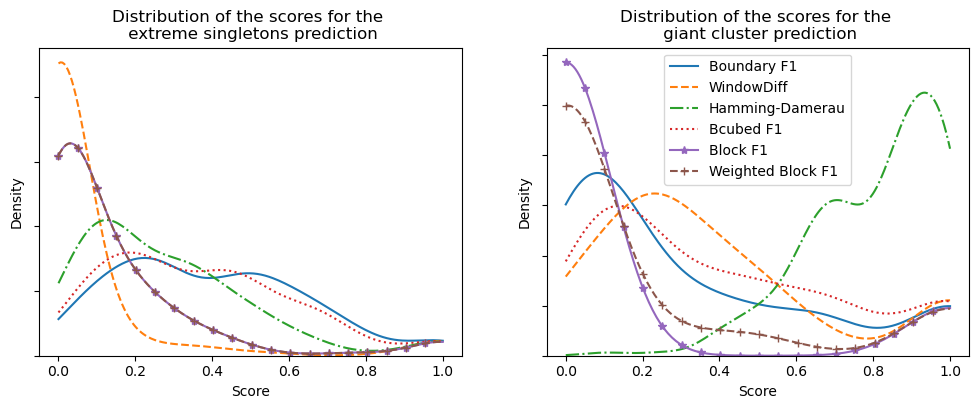

In [22]:
fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=2)
p1 = plot_KDE(singleton_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']], ax=axes[0])
p1.set_title('Distribution of the scores for the \n extreme singletons prediction')
p1.set_xlabel('Score')
p2 = plot_KDE(giant_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']], ax=axes[1])
p2.set_title('Distribution of the scores for the \n giant cluster prediction')
p2.set_xlabel("Score")
plt.legend()
plt.savefig('DocumentSplitting/images/extreme_plots_wooir.png')
plt.show()

In [23]:
extremes_df = pd.DataFrame({'singletons': singleton_scores, 'giant cluster': giant_scores})
extremes_df.round(2).sort_index().T

,Accuracy,Bcubed F1,Block F1,Boundary F1,Hamming-Damerau,Weighted Block F1,WindowDiff,distance_to_bounds
singletons,0.28,0.37,0.14,0.40,0.28,0.14,0.08,0.78
giant cluster,0.81,0.40,0.14,0.32,0.81,0.19,0.38,0.35


In [24]:
singleton_df.corr()

,Boundary F1,Bcubed F1,Accuracy,Hamming-Damerau,WindowDiff,Block F1,distance_to_bounds,Weighted Block F1
Boundary F1,1.000000,0.995450,0.977850,0.977850,0.673945,0.769953,0.448026,0.769953
Bcubed F1,0.995450,1.000000,0.982863,0.982863,0.690615,0.761880,0.414326,0.761880
Accuracy,0.977850,0.982863,1.000000,1.000000,0.801279,0.860310,0.422089,0.860310
Hamming-Damerau,0.977850,0.982863,1.000000,1.000000,0.801279,0.860310,0.422089,0.860310
WindowDiff,0.673945,0.690615,0.801279,0.801279,1.000000,0.939633,0.291738,0.939633
Block F1,0.769953,0.761880,0.860310,0.860310,0.939633,1.000000,0.384085,1.000000
distance_to_bounds,0.448026,0.414326,0.422089,0.422089,0.291738,0.384085,1.000000,0.384085
Weighted Block F1,0.769953,0.761880,0.860310,0.860310,0.939633,1.000000,0.384085,1.000000


Ok, dit is wel interessant, accuracy heeft een correlatie van 1 met Hamming Damerau. Dit te verklaren door de extremen. Als een stream alleen nullen heeft moeten er $n$ substituties gedaan worden om dit naar de gold standard om te zetten. Dit is steeds een operatie, en is dus gelijk aan de accuracy. Hetzelfde verhaal voor het giant cluster.

In [25]:
extremes_df

,singletons,giant cluster
Boundary F1,0.398801,0.323184
Bcubed F1,0.371169,0.404622
Accuracy,0.284037,0.805462
Hamming-Damerau,0.284037,0.805462
WindowDiff,0.076805,0.379350
Block F1,0.141028,0.139738
distance_to_bounds,0.784158,0.352433
Weighted Block F1,0.141028,0.186465


<a id='fixed_page'></a>

## Fixed page baselines

In [26]:
# Dit experiment is meer gericht op de verschillende scores tussen de opties
# dus hier doe ik automatisch meerdere runs
def fixed_page_baseline(gold_standard_json, max_num_pages):
    fixed_scores = {}
    for doc_size in tqdm(np.arange(2, max_num_pages)):
        doc_scores = {}
        for doc_id, cluster_key in gold_standard_json.items():
            bin_vec = length_list_to_bin(cluster_key)
            fixed_baseline = fixedpage(bin_vec, document_size=doc_size)
            doc_scores[doc_id] = calculate_metrics(bin_vec, fixed_baseline)
        aggregated_metrics = pd.DataFrame(doc_scores).T.mean()
        fixed_scores[doc_size] = aggregated_metrics
    fixed_scores = pd.DataFrame(fixed_scores).T
    return fixed_scores

100%|██████████| 14/14 [01:28<00:00,  6.30s/it]


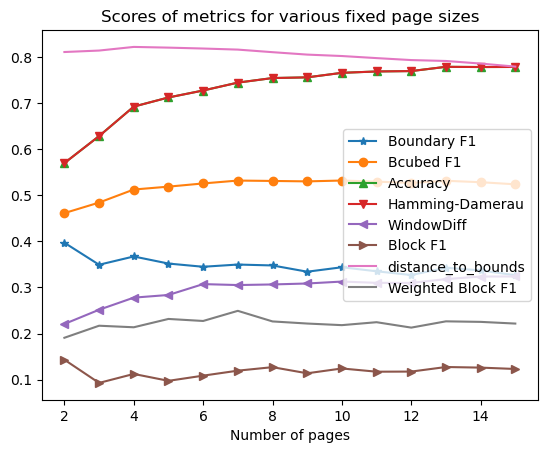

In [27]:
fixed_df = fixed_page_baseline(combined_set, max_num_pages=16)
fixed_df.plot(xlabel="Number of pages", title="Scores of metrics for various fixed page sizes",
             style=['*-','o-','^-', 'v-', '<-', '>-'])
plt.savefig('DocumentSplitting/images/fixedpage_baseline_wooir.png')
plt.show()

<a id='corpus_level'></a>

## Corpus level stats

Hier run ik de baselines die gebruik maken van de mean en median van de document lengte genomen over het hele corpus.

### waardes
Hier print ik gelijk eventjes wat de mean en median zijn voor het hele corpus (test + train voor beide corpora)

In [28]:
all_docs = []
for stream in combined_set.values():
    all_docs.extend(stream)
mean_num_pages = pd.Series(all_docs).mean()
median_num_pages = int(pd.Series(all_docs).median())
print("Mean: %.2f, median: %d" % (mean_num_pages, median_num_pages))

Mean: 6.32, median: 2


In [29]:
def corpus_level_baseline(gold_standard_json, kind='mean'):
    all_docs = []
    for stream in gold_standard_json.values():
        all_docs.extend(stream)
    mean_num_pages = int(pd.Series(all_docs).mean())
    median_num_pages = int(pd.Series(all_docs).median())

    stream_stats_corpus = {}
    for i, (doc_id, stream) in enumerate(gold_standard_json.items()):
        bin_vec = length_list_to_bin(stream)
        if kind == 'mean':
            baseline = fixedpage(bin_vec, mean_num_pages)
        elif kind == 'median':
            baseline = fixedpage(bin_vec, median_num_pages)
        else:
            raise Exception
            
        stream_stats_corpus[doc_id] = calculate_metrics(bin_vec, baseline)
    stream_stats = pd.DataFrame(stream_stats_corpus).T
    return stream_stats, stream_stats.mean()

In [30]:
corpus_mean_df, corpus_mean_scores = corpus_level_baseline(combined_set, kind='mean')
corpus_median_df, corpus_median_scores = corpus_level_baseline(combined_set, kind='median')

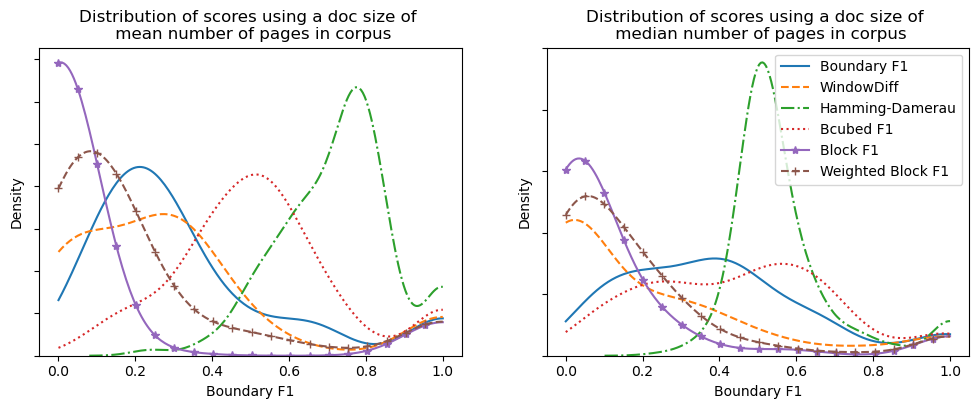

In [33]:
fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=2)
p1 = plot_KDE(corpus_mean_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']], ax=axes[0])
p1.set_title("Distribution of scores using a doc size of \n mean number of pages in corpus")
p2 = plot_KDE(corpus_median_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']], ax=axes[1])
p2.set_title("Distribution of scores using a doc size of \n median number of pages in corpus")
plt.legend()
plt.show()

Hamming en accuracy zien hier bijna gelijk. Dit komt natuurlijk omdat ze elkaars inverse zijn, en ze nu allebei een gemiddelde in de buurt van 0.50 hebben

In [ ]:
corp_level_df = pd.DataFrame({'corpus mean': corpus_mean_scores, 'corpus median': corpus_median_scores})
corp_level_df.round(2).sort_index().T

<a id='stream_level'></a>

## Stream level stats

Hier run ik baselines die de mean en median van het aantal documenten berekent per stream. Het kan dus per stream steeds weer anders zijn welke waar het heeft.

In [34]:
def stream_level_baseline(gold_standard_json, kind='mean'):

    stream_level_stats = {}
    for i, (doc_id, stream) in enumerate(gold_standard_json.items()):
        bin_vec = length_list_to_bin(stream)
        if kind == 'mean':
            baseline = fixedpage(bin_vec, int(pd.Series(stream).mean()))
        elif kind == 'median':
            baseline = fixedpage(bin_vec, int(pd.Series(stream).median()))
        else:
            raise Exception
            
        stream_level_stats[doc_id] = calculate_metrics(bin_vec, baseline)
    stream_stats = pd.DataFrame(stream_level_stats).T
    return stream_stats, stream_stats.mean()

In [35]:
stream_mean_df, stream_mean_scores = stream_level_baseline(combined_set, kind='mean')
stream_median_df, stream_median_scores = stream_level_baseline(combined_set, kind='median')

In [36]:
stream_level_df = pd.DataFrame({'stream mean': stream_mean_scores, 'stream median': stream_median_scores})
stream_level_df.round(2).sort_index().T

,Accuracy,Bcubed F1,Block F1,Boundary F1,Hamming-Damerau,Weighted Block F1,WindowDiff,distance_to_bounds
stream mean,0.76,0.63,0.25,0.46,0.76,0.38,0.44,0.89
stream median,0.70,0.60,0.28,0.48,0.70,0.39,0.42,0.88


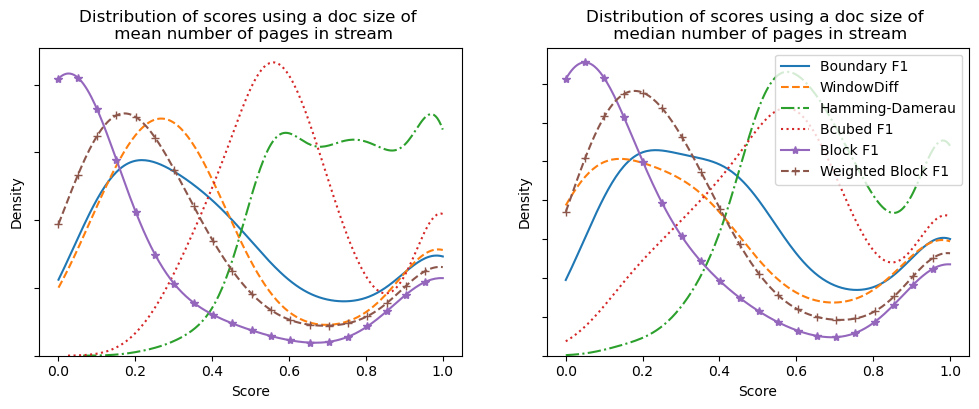

In [39]:
fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=2)
p1 = plot_KDE(stream_mean_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']], ax=axes[0])
p1.set_title("Distribution of scores using a doc size of \n mean number of pages in stream")
p1.set_xlabel('Score')
p2 = plot_KDE(stream_median_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']], ax=axes[1])
p2.set_title("Distribution of scores using a doc size of \n median number of pages in stream")
p2.set_xlabel('Score')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
linestyles = ['-', '--', '-.', ':', '-', '--']
markers = ['*', '+']
for i, metric in enumerate(stream_mean_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']].columns):
    if i >= 4:
        marker = markers[i % 4]
    else:
        marker = ''
    sns.kdeplot(stream_mean_df[metric], linestyle=linestyles[i], clip=[0, 1], label=metric, marker=marker,
               markevery=10)
plt.xlabel('Score')
ax.set_yticklabels([])
plt.legend()
plt.savefig("DocumentSplitting/images/stream_mean_kde.png")
plt.show()

<a id='plot_experiment'></a>

### Klein plot experiment

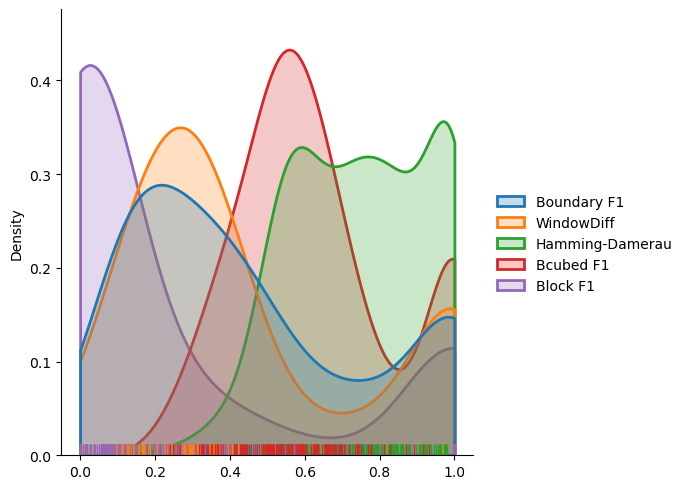

In [42]:
#fig, ax = plt.subplots(nrows=1, ncols=1)
sns.displot(stream_mean_df[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1']],
             kind='kde', clip=[0, 1], rug=True, linewidth=2, rug_kws={'color': 'black'}, fill=True,
           bw_adjust=1)
plt.show()

Die shading ziet er wel goed uit op dit plaatje, die kan ik misschien ook wel toevoegen in het paper, die rug plot wordt nogal onverzichtelijk door de verxhillende lijnen die we erin hebben zitten.

<a id='bimodal'></a>

### Bimodale verdeling van scores

Hier gaan we eens kijken naar de bimodale verdeling in de scores die we lijken te zien voor de meeste metrics. We nemen bcubed als voorbeeld.

In [ ]:
b3_scores = stream_mean_df['Bcubed F1']

In [ ]:
high_scores_b3 = b3_scores[b3_scores > 0.9]
# haal voorbeelden op

for doc_id in high_scores_b3.index:
    print("Bcubed F1: ", high_scores_b3[doc_id])
    print("Actual Stream: ", combined_set[doc_id])
    print('\n')


Ok die bump rond 1 is dus eigenlijk vrij flauw, het zijn ofwel streams met maar 1 document, ofwel streams waarbij elk document een gelijk aantal pagina's heeft en je dus altijd goed zit met je mean en je median. Ook eens kijken naar scores die 'redelijk' zijn.

In [ ]:
decent_scores_b3 = b3_scores[(b3_scores > 0.4) & (b3_scores < 0.7)]
# haal voorbeelden op

for doc_id in decent_scores_b3.index[:20]:
    print("Bcubed F1: ", decent_scores_b3[doc_id])
    print("Stream mean: %d" % pd.Series(combined_set[doc_id]).mean())
    print("Actual Stream: ", combined_set[doc_id])
    print('\n')



Als we kijken naar de waardes die in de middenrange vallen zien we veel meer variatie, en dat er gewoon een aantal stream zijn waar de mean redelijk goed werkt.

In [ ]:
stream_level_df.T['Block F1'].round(2)

Ik maak even een plotje van de mean en mediaan verdeling, dit helpt met de uitleg.

In [ ]:
stream_means = pd.Series([int(pd.Series(item).mean()) for item in combined_set.values()])
stream_medians = pd.Series([int(pd.Series(item).median()) for item in combined_set.values()])
stream_df = pd.DataFrame({'Stream median': stream_medians, 'Stream mean': stream_means})
stream_df.plot(kind='kde')
plt.savefig('mean_and_median_stream_distributions.png')
plt.show()

In [ ]:
stream_means.mean().round(2), stream_medians.mean().round(2)

In [ ]:
stream_means.std().round(2), stream_medians.std().round(2)

Ik plot hier de means als integers, dit omdat float waardes in het geval van het maken van de stream geen betekenis hebben. (docs van 3.5 paginas bijvoorbeeld)

Bijna gelijk maar wel lastig te zien zo, misschien even een boxplot / histogram doen

<a id='clustering'></a>

## Hierachical Clustering approach

Hier doe ik hierarchical clustering op de karakter ngrammen, en over alle data, dus train en test gecombineerd. 

In [43]:
corpus_1_text = pd.read_csv('../Desktop/wobir_train_and_test/corpus1/TrainTestSet/TrainSet/ocred_text.csv.gz').fillna('')
corpus_1_text['joined_name'] = corpus_1_text['name'].str.replace('__concatenated', '')
corpus_1_text = corpus_1_text.sort_values(by=['joined_name', 'page'])

corpus_2_text_train = pd.read_csv('../Desktop/wobir_train_and_test/corpus2/TrainTestSet/TrainSet/ocred_text.csv.gz').fillna('')
corpus_2_text_train['joined_name'] = corpus_2_text_train['name'].str.replace('__concatenated', '')
corpus_2_text_train = corpus_2_text_train.sort_values(by=['joined_name', 'page'])
 
corpus_2_text_test = pd.read_csv('../Desktop/wobir_train_and_test/corpus2/TrainTestSet/TestSet/ocred_text.csv.gz').fillna('')
corpus_2_text_test['joined_name'] = corpus_2_text_test['name'].str.replace('__concatenated', '')
corpus_2_text_test = corpus_2_text_test.sort_values(by=['joined_name', 'page'])

In [44]:
# Eerst even alles opzetten.
import networkx as nx
import itertools
import scipy
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def create_connectivity_matrix(number_of_pages: int):
    G = nx.Graph() 
    nx.add_path(G, list(range(number_of_pages)))
    return nx.adjacency_matrix(G)    

def predict(list_of_pages: list, num_docs, ngrams: tuple = (2, 3), word_or_char: str = 'char_wb'):
    
        vectorizer_algorithm = TfidfVectorizer(analyzer=word_or_char, ngram_range=ngrams)
        
        if len(list_of_pages) == 1:
            return [1]
        
        # Now we create the page vectors from the vectorizer
        page_vectors = vectorizer_algorithm.fit_transform(list_of_pages)
        
        connectivity_matrix = create_connectivity_matrix(page_vectors.shape[0])
        
        cluster_algorithm = AgglomerativeClustering(linkage='single',
                                                         affinity='cosine',
                                                         n_clusters=num_docs,
                                                    connectivity=connectivity_matrix)

        # Add a small value to the array to account for all zero rows
        cluster_algorithm.fit(np.asarray(page_vectors.todense())+0.000001)

        consec_blocks = [len(list(group)) for bit, group in itertools.groupby(cluster_algorithm.labels_)]
        return consec_blocks

In [45]:
# Ik gebruik hier corpus 2 als test, die staat netjes los in de csv
def get_training_data(ground_truth, text_df):
    train_data = text_df[text_df['joined_name'].isin(list(ground_truth.keys()))]
    # nu weten we zeker dat de pagina's goed gesorteerd zijn.
    train_data_sorted  = train_data.sort_values(by=['joined_name', 'page'])
    
    train_data_dict = {}
    
    # nu kunnen we onze data in een dict zetten, met als key de 
    # filename
    for group_id, group_data in train_data_sorted.groupby('joined_name'):
        train_data_dict[group_id] = group_data['text'].tolist()
    
    y = {key:val for key, val in ground_truth.items() if key in train_data_dict.keys()}
    
    return train_data_dict, y

In [46]:
all_text_df = pd.concat([corpus_1_text, corpus_2_text_train, corpus_2_text_test])
# all gold standard is combined_set

In [47]:
all_X, all_y = get_training_data(combined_set, all_text_df)
predicted_streams = {}
cluster_scores = {}

for doc_id in tqdm(all_y.keys()):
    out = predict(all_X[doc_id], len(all_y[doc_id]), ngrams=(2, 5))
    predicted_streams[doc_id] = out
    cluster_scores[doc_id] = calculate_metrics(length_list_to_bin(all_y[doc_id]), length_list_to_bin(out))

  0%|          | 0/165 [00:00<?, ?it/s]/Users/rvanheusden/anaconda3/envs/DutchRoberta/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
  1%|          | 1/165 [00:03<09:16,  3.40s/it]/Users/rvanheusden/anaconda3/envs/DutchRoberta/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
  1%|          | 2/165 [00:04<07:19,  2.69s/it]/Users/rvanheusden/anaconda3/envs/DutchRoberta/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
  2%|▏         | 3/165 [00:06<06:34,  2.43s/it]/Users/rvanheusden/anaconda3/envs/DutchRoberta/lib/python3.9/

In [48]:
hierarch_scores = pd.DataFrame(cluster_scores).T
hierarch_scores.mean().round(2)

Boundary F1           0.56
Bcubed F1             0.68
Accuracy              0.81
Hamming-Damerau       0.81
WindowDiff            0.50
Block F1              0.32
distance_to_bounds    0.90
Weighted Block F1     0.43
dtype: float64

In [61]:
# filter based on singleton streams
singleton_streams = [key for key in combined_set if len(combined_set[key]) == 1]
no_singleton_streams_df = hierarch_scores[~hierarch_scores.index.isin(singleton_streams)]

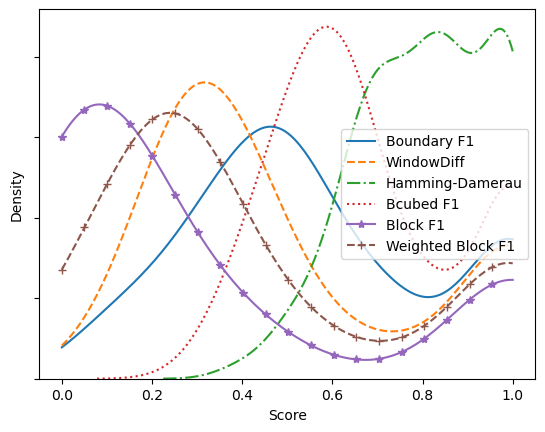

In [65]:
fig, ax = plt.subplots()
linestyles = ['-', '--', '-.', ':', '-', '--']
markers = ['*', '+']
for i, metric in enumerate(hierarch_scores[['Boundary F1', 'WindowDiff', 'Hamming-Damerau', 'Bcubed F1', 'Block F1', 'Weighted Block F1']].columns):
    if metric == 'HammingDamerau':
        l = 'Hamming-Damerau'
    elif metric == 'IoU F1':
        l = 'Weighted Block F1'
    else:
        l = metric
        
    if i >= 4:
        marker = markers[i % 4]
    else:
        marker = ''
    
    sns.kdeplot(no_singleton_streams_df[metric], linestyle=linestyles[i], clip=[0, 1], label=l, bw_adjust=1,
               marker=marker, markevery=10)
plt.xlabel('Score')
ax.set_yticklabels([])
plt.legend()
plt.savefig("DocumentSplitting/images/hierach_clustering_kde.png")
plt.show()

## Onderzoekje naar hoge bimodale verdeling voor clustering approach

Als eerste wil ik eventjes die plots zoals hierboven maken, maar dan met bijna geen smoothing, dan is het beter te zien of die bump er ook echt is.

In [ ]:
fig, ax = plt.subplots()
linestyles = ['-', '--', '-.', ':', '-']
for i, metric in enumerate(hierarch_scores[['Boundary F1', 'WindowDiff', 'HammingDamerau', 'Bcubed F1', 'Block F1']].columns):
    sns.kdeplot(hierarch_scores[metric], linestyle=linestyles[i], clip=[0, 1], label=metric, bw_adjust=0.5)
plt.xlabel('Score')
ax.set_yticklabels([])
plt.legend()
plt.savefig("DocumentSplitting/images/hierach_clustering_kde.png")
plt.show()

In [ ]:
b3_clust_scores = hierarch_scores['Bcubed F1']

In [ ]:
# pak weer de hele hoge scores van bcubed
high_scores_b3_clust = b3_clust_scores[b3_clust_scores > 0.9]
# haal voorbeelden op

for doc_id in high_scores_b3_clust.index:
    print("Bcubed F1: ", high_scores_b3_clust[doc_id])
    print("Actual Stream: ", combined_set[doc_id])
    print('\n')



Ok interessant om te zien, de meeste van die perfecte scores komen nog steeds doordat we single document stream hebben, maar er zitten er ook een aantal tussen waar we het gewoon goed hebben zonder dat we echt iets heel 'simpels' hebben. Wel is te zien dat dit dan vaak gaat om stream van 2 of 3 documenten. Sowieso zorgt het geven van het aantal clusters aan het systeem soms voor semi-triviale gevallen. Als je bijvoorbeeld 10 pagina's hebt en weet dat je 8 of 9 documenten moet hebben is het niet moeilijk om daar een hoge score voor te krijgen.